In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import os
import pydensecrf.densecrf as dcrf
import pydensecrf.utils as utils
from matplotlib.patches import Patch
import webcolors

In [2]:
def str_to_int(x):
    ans = []
    for char in x.split(" "):
        ans.append(int(char))
    return np.array(ans)

def cls_split(df, im_shape=(256, 256)):
    
    df["ImArr"] = df.PredictionString.map(str_to_int)
    rtn = []
    for i in tqdm(range(len(df))):
        re = np.reshape(df["ImArr"][i][:,np.newaxis],im_shape)
        cls_split = []
        for i in range(11):
            buf = np.zeros(im_shape)
            buf[re==i] = 1
            cls_split.append(buf)
        cls_split = np.array(cls_split)
        rtn.append(cls_split)
    return np.array(rtn)

In [3]:
def dense_crf(
    img, output_probs,
    MAX_ITER, POS_XY_STD, POS_W,
    Bi_XY_STD, Bi_RGB_STD, Bi_W
    
):
    c = output_probs.shape[0]
    h = output_probs.shape[1]
    w = output_probs.shape[2]

    U = utils.unary_from_softmax(output_probs)
    U = np.ascontiguousarray(U)

    img = np.ascontiguousarray(img)

    d = dcrf.DenseCRF2D(w, h, c)
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(
        sxy=POS_XY_STD, compat=POS_W
    )
    d.addPairwiseBilateral(
        sxy=Bi_XY_STD, srgb=Bi_RGB_STD, rgbim=img, compat=Bi_W
    )

    Q = d.inference(MAX_ITER)
    Q = np.array(Q).reshape((c, h, w))
    return Q

def get_label_map(
    im_path, prediction,
    MAX_ITER, POS_XY_STD, POS_W,
    Bi_XY_STD, Bi_RGB_STD, Bi_W
):
    
    # Image preprocessing
    scale = 0.5
    image = cv2.imread(im_path, cv2.IMREAD_COLOR).astype(float)
    image = cv2.resize(image, dsize=None, fx=scale, fy=scale)
    image_original = image.astype(np.uint8)
    image = image.transpose(2, 0, 1)

    # Inference
    # output = model(image)
    # output = F.interpolate(
    #     output, size=image.shape[2:], mode="bilinear", align_corners=True
    # )
    # output = F.softmax(output, dim=1) ::: channel first
    # output = output.data.cpu().numpy()[0]

    output = dense_crf(
                image_original, prediction,
                MAX_ITER, POS_XY_STD, POS_W,
                Bi_XY_STD, Bi_RGB_STD, Bi_W
            )
    labelmap = np.argmax(output, axis=0)
    
    return image_original, labelmap

In [4]:
class_colormap = [[0,0,0],
               [192,0,128],
               [0,128,192],
               [0,128,64],
               [128,0,0],
               [64,0,128],
               [64,0,192],
               [192,128,64],
               [192,192,128],
               [64,64,128],
               [128,0,192]]
CLASSES = ("Backgroud", "General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing")

In [5]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (r, g, b) in enumerate(class_colormap):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

In [6]:
csv_name_list = [f'output ({i}).csv' for i in range(11)]
w_cls_split_arr, cls_split_arr = None, None
for i, csv_name in enumerate(csv_name_list):
    print(csv_name)
    df = pd.read_csv(csv_name)[:100]
    weight = (len(csv_name_list)//3 + 1)
    if cls_split_arr is None :
        cls_split_arr = cls_split(df)
        w_cls_split_arr = w_cls_split(df) * weight
    else:
        cls_split_arr += cls_split(df)
        w_cls_split_arr += w_cls_split(df) * weight
        
cls_prob = cls_split_arr/len(csv_name_list)
w_cls_prob = w_cls_split_arr/len(csv_name_list)
print("done")

output (0).csv


100%|██████████| 100/100 [00:00<00:00, 201.48it/s]


output (1).csv


100%|██████████| 100/100 [00:00<00:00, 291.94it/s]


output (2).csv


100%|██████████| 100/100 [00:00<00:00, 269.15it/s]


output (3).csv


100%|██████████| 100/100 [00:00<00:00, 278.84it/s]


output (4).csv


100%|██████████| 100/100 [00:00<00:00, 262.48it/s]


output (5).csv


100%|██████████| 100/100 [00:00<00:00, 271.51it/s]


output (6).csv


100%|██████████| 100/100 [00:00<00:00, 262.73it/s]


output (7).csv


100%|██████████| 100/100 [00:00<00:00, 261.26it/s]


output (8).csv


100%|██████████| 100/100 [00:00<00:00, 263.90it/s]


output (9).csv


100%|██████████| 100/100 [00:00<00:00, 265.09it/s]


output (10).csv


100%|██████████| 100/100 [00:00<00:00, 257.34it/s]


done


In [7]:
im_dir = "/opt/ml/segmentation/input/data/"
k = 10*0

num_examples = 5
index = 0


def vis(
    num_examples = 5,
    index = 0,
    MAX_ITER = 5, # 15 # 10
    POS_W = 3,
    POS_XY_STD = 1,
    Bi_W = 4,
    Bi_XY_STD =  30, # 20 # 67
    Bi_RGB_STD = 90, # 100 # 3
):

    submissions = csv_name_list[:3]

    category_and_rgb = [[CLASSES[idx], (r,g,b)] for idx, (r, g, b) in enumerate(class_colormap)]
    legend_elements = [Patch(facecolor=webcolors.rgb_to_hex(rgb), 
                             edgecolor=webcolors.rgb_to_hex(rgb), 
                             label=category) for category, rgb in category_and_rgb]

    masks_lst = []
    for idx, submission_path in enumerate(submissions):
        submission = pd.read_csv(
            submission_path,
            index_col=None
        )[index : index + num_examples]

        # mask load
        masks = submission["PredictionString"].values
        for m in range(num_examples):
            mask = list(map(int, masks[m].split()))
            mask = np.array(mask)
            mask = np.reshape(mask, (-1, 256))
            masks[m] = mask
        masks_lst.append(masks)

    # plt 생성
    fig, ax = plt.subplots(
        nrows=num_examples, 
        ncols=len(submissions)+3, 
        figsize=(20, 4*num_examples), 
        constrained_layout=True
    )


    for row_num in range(num_examples):
        im_name = df.image_id[index + row_num]
        im_path = im_dir + im_name
        prediction = cls_prob[index + row_num]

        image_original, labelmap = get_label_map(
            im_path, prediction,
            MAX_ITER, POS_XY_STD, POS_W,
            Bi_XY_STD, Bi_RGB_STD, Bi_W
        )

        # Original Image
        ax[row_num][0].imshow(image_original)
        ax[row_num][0].set_title(f"Orignal: {im_name}")
        ax[row_num][0].axis('off')

        for i in range(len(submissions)):
            # Pred Mask
            ax[row_num][i+1].imshow(label_to_color_image(masks_lst[i][row_num]))
            ax[row_num][i+1].set_title(f"{submissions[i]}")
            ax[row_num][i+1].axis('off')

        # Pred Mask
        ax[row_num][i+2].imshow(label_to_color_image(np.argmax(prediction, axis=0)[::2,::2]))
        ax[row_num][i+2].set_title('weighted hard vote')
        ax[row_num][i+2].axis('off')
        
        ax[row_num][i+3].imshow(label_to_color_image(labelmap))
        ax[row_num][i+3].set_title('weighted prob_CRF')
        ax[row_num][i+3].axis('off')
        
        ax[row_num][i+3].legend(
            handles=legend_elements, 
            bbox_to_anchor=(1.05, 1), 
            loc=2, borderaxespad=0
        )
    plt.show()

In [8]:
kwargs = dict(
    MAX_ITER=10, # 15 # 10
    POS_W=0,
    POS_XY_STD=1,
    Bi_W=1,
    Bi_XY_STD=25, # 20 # 67
    Bi_RGB_STD=25, # 100 # 3
)

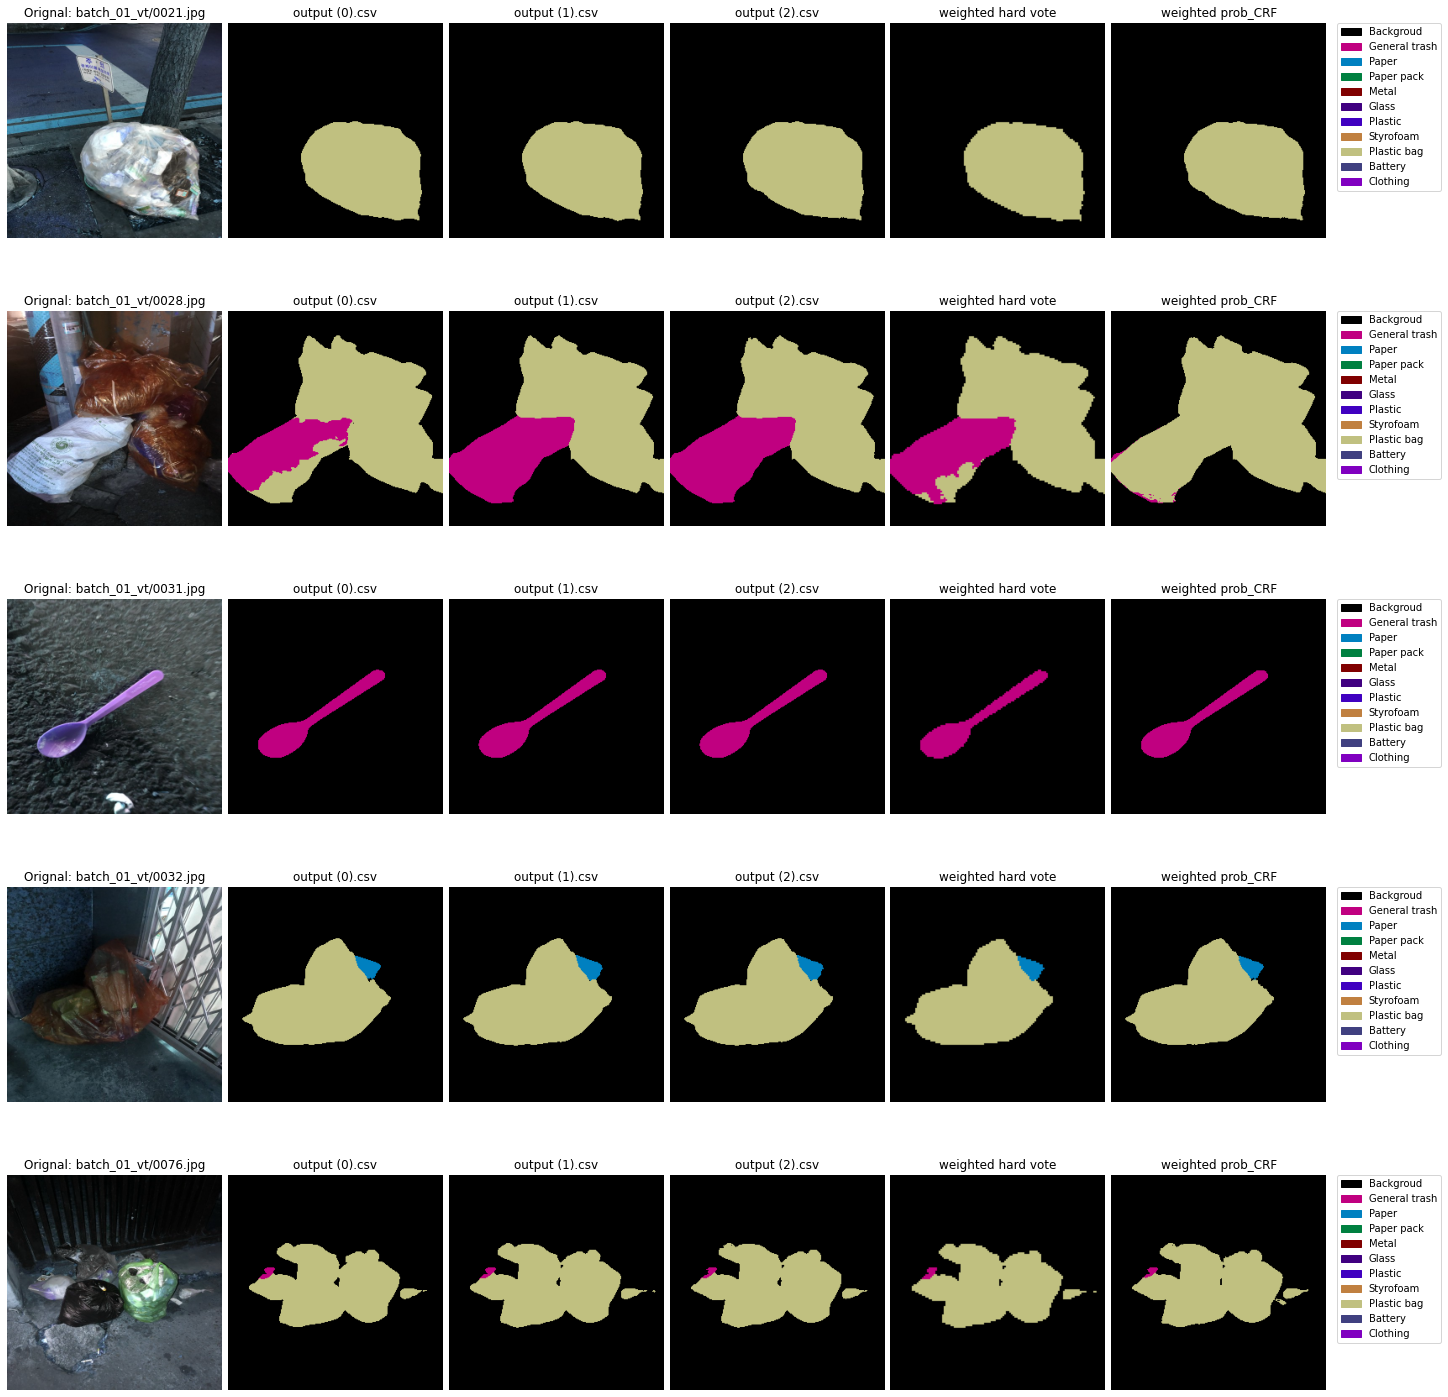

In [9]:
vis(index = 0*num_examples, **kwargs)

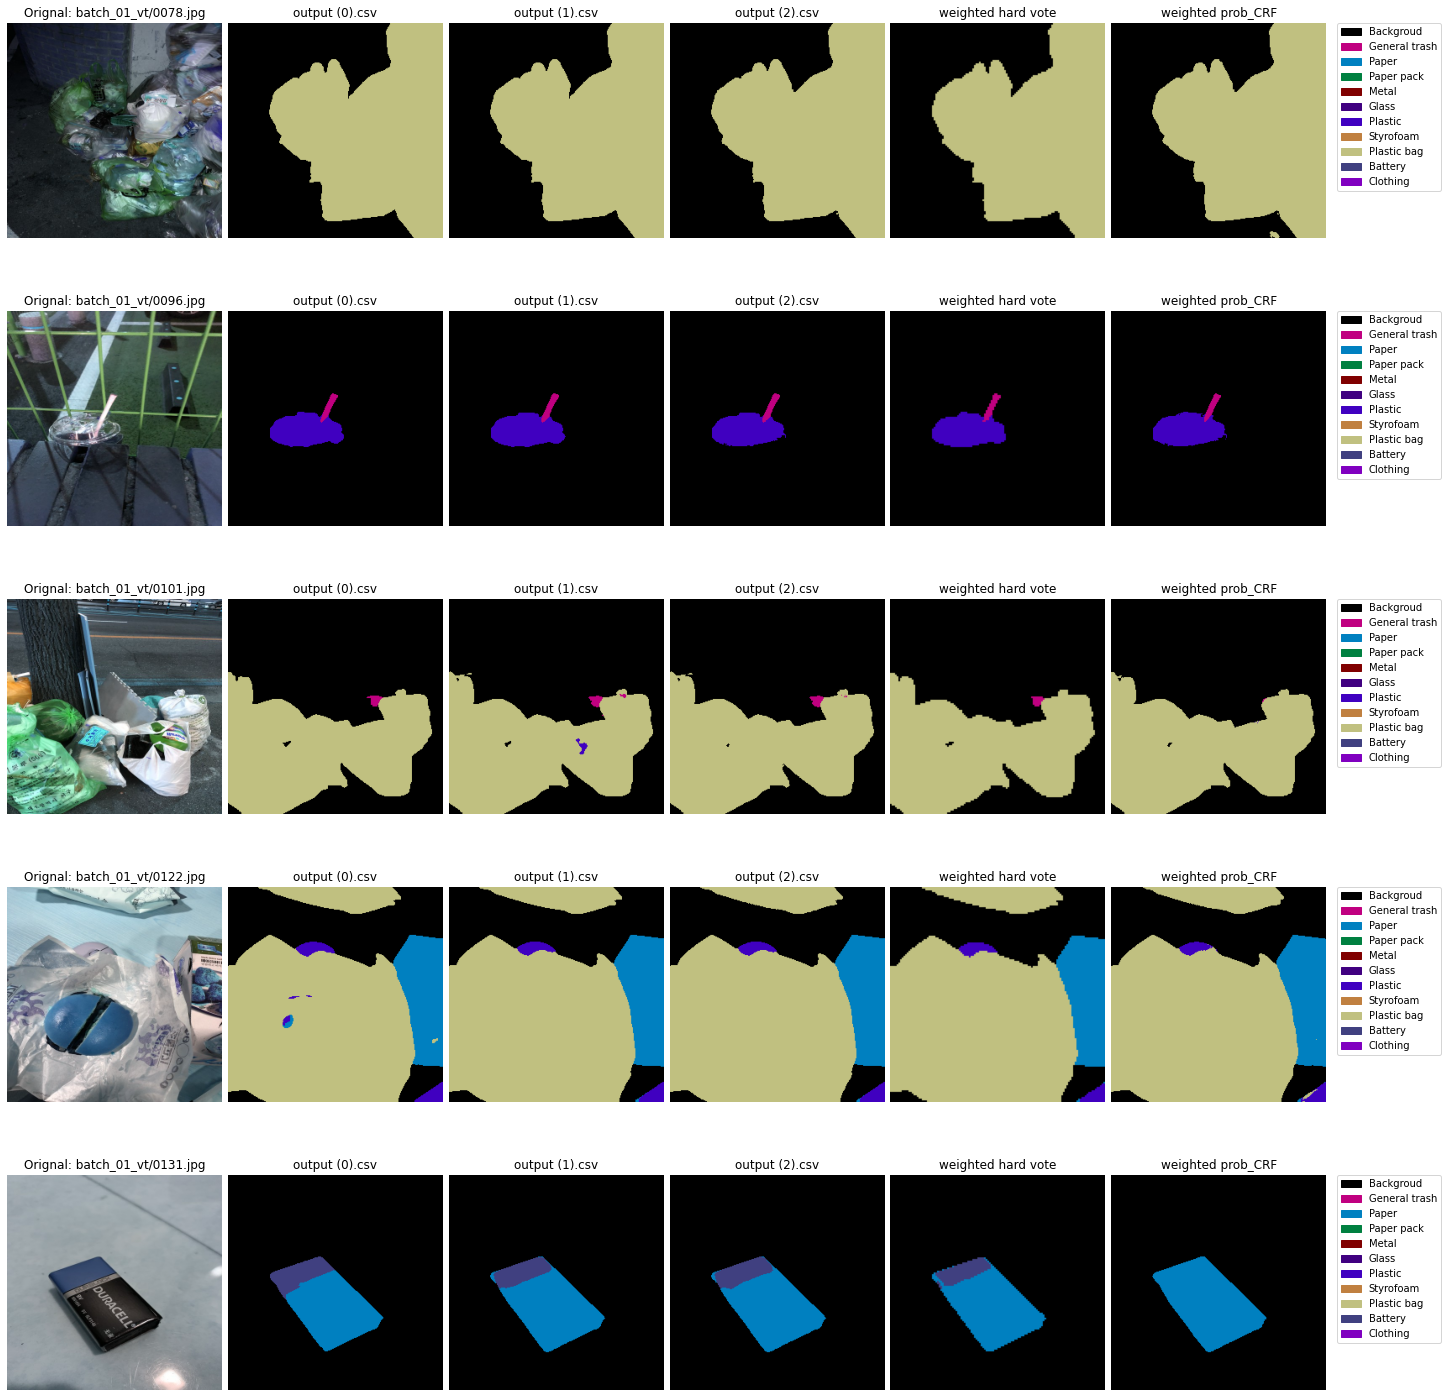

In [10]:
vis(index = 1*num_examples, **kwargs)

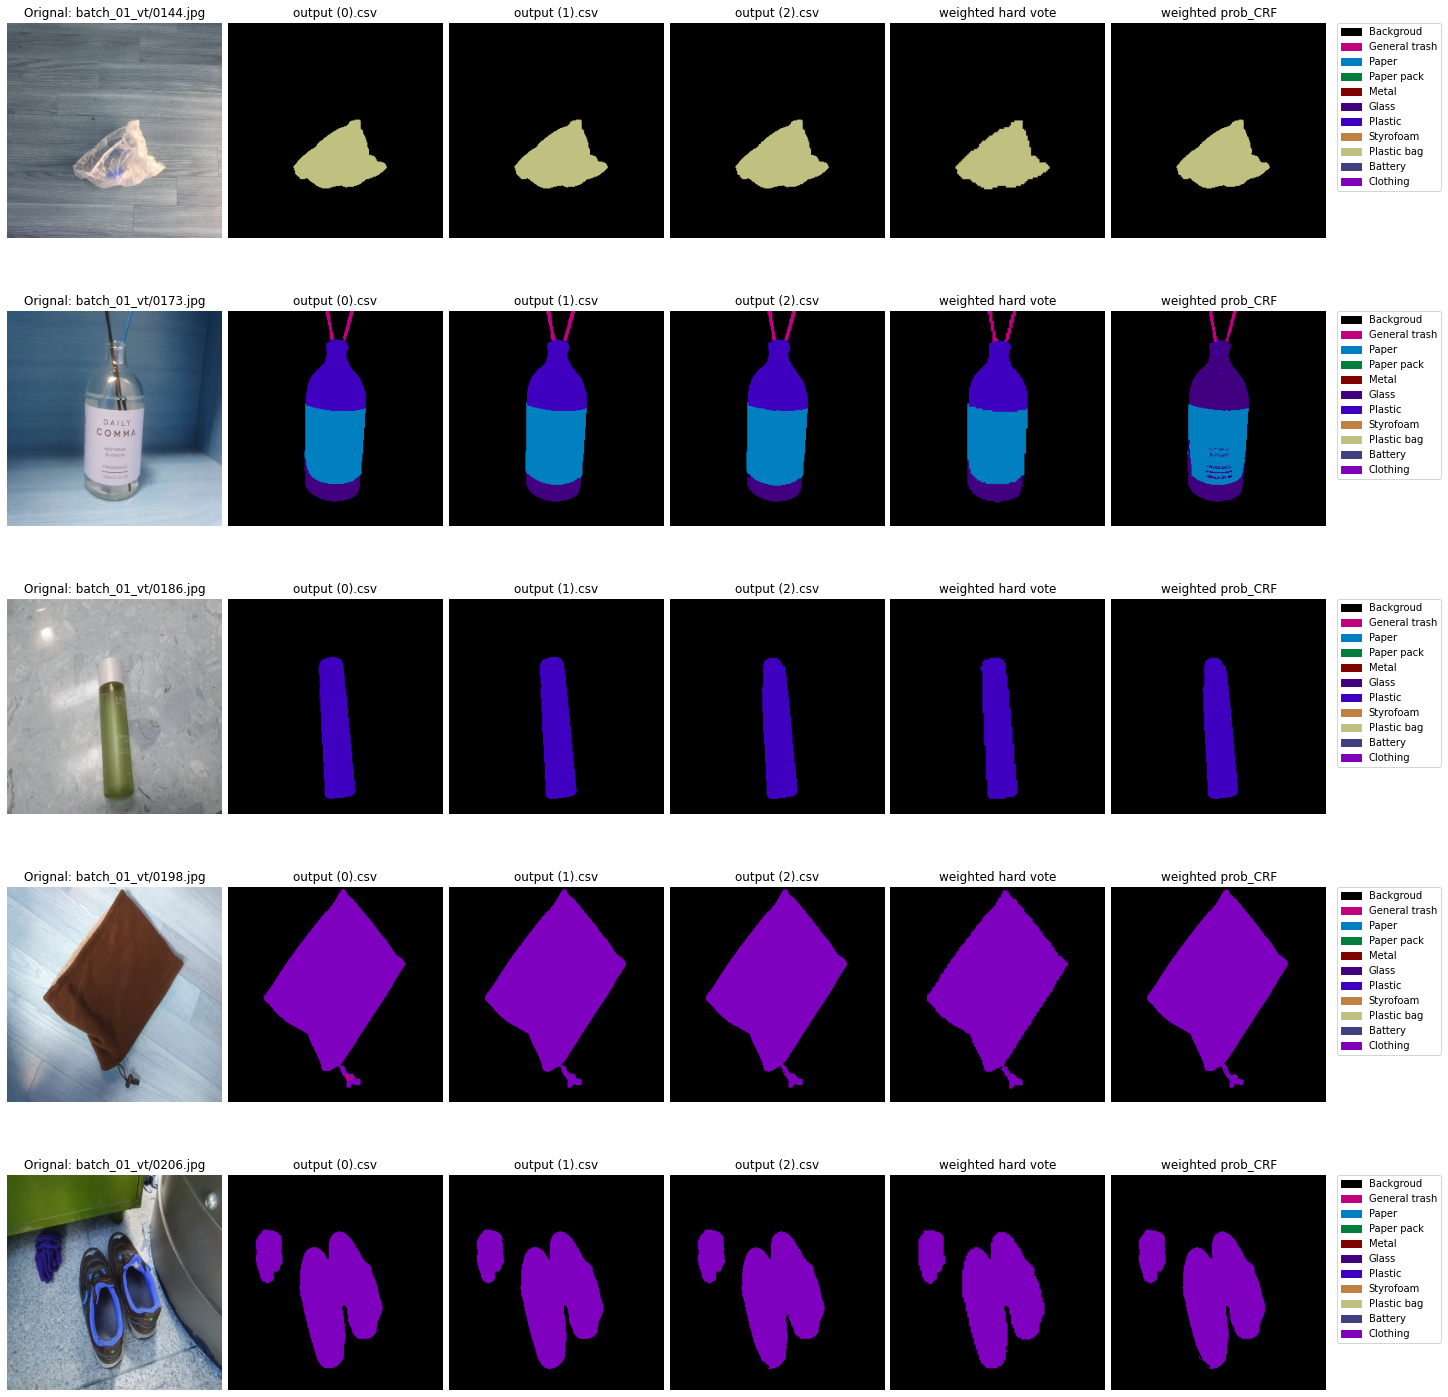

In [11]:
vis(index = 2*num_examples, **kwargs)

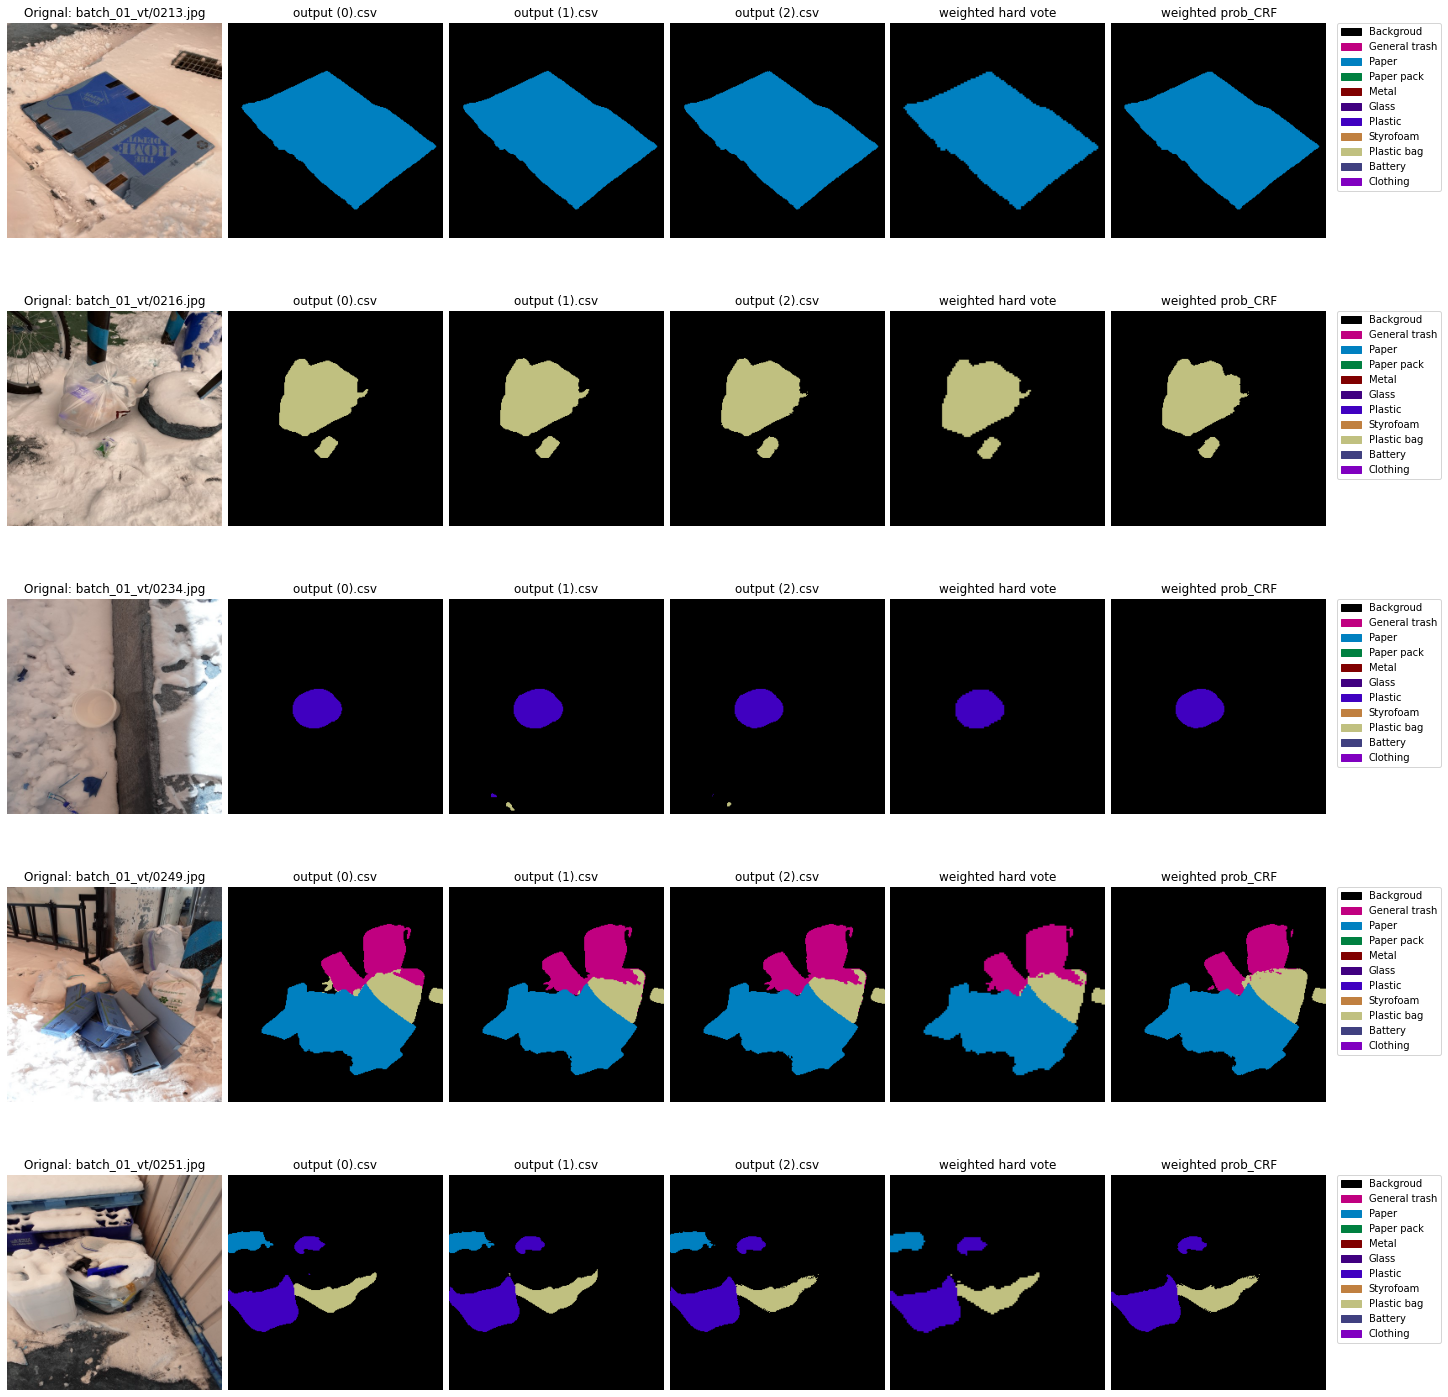

In [12]:
vis(index = 3*num_examples, **kwargs)

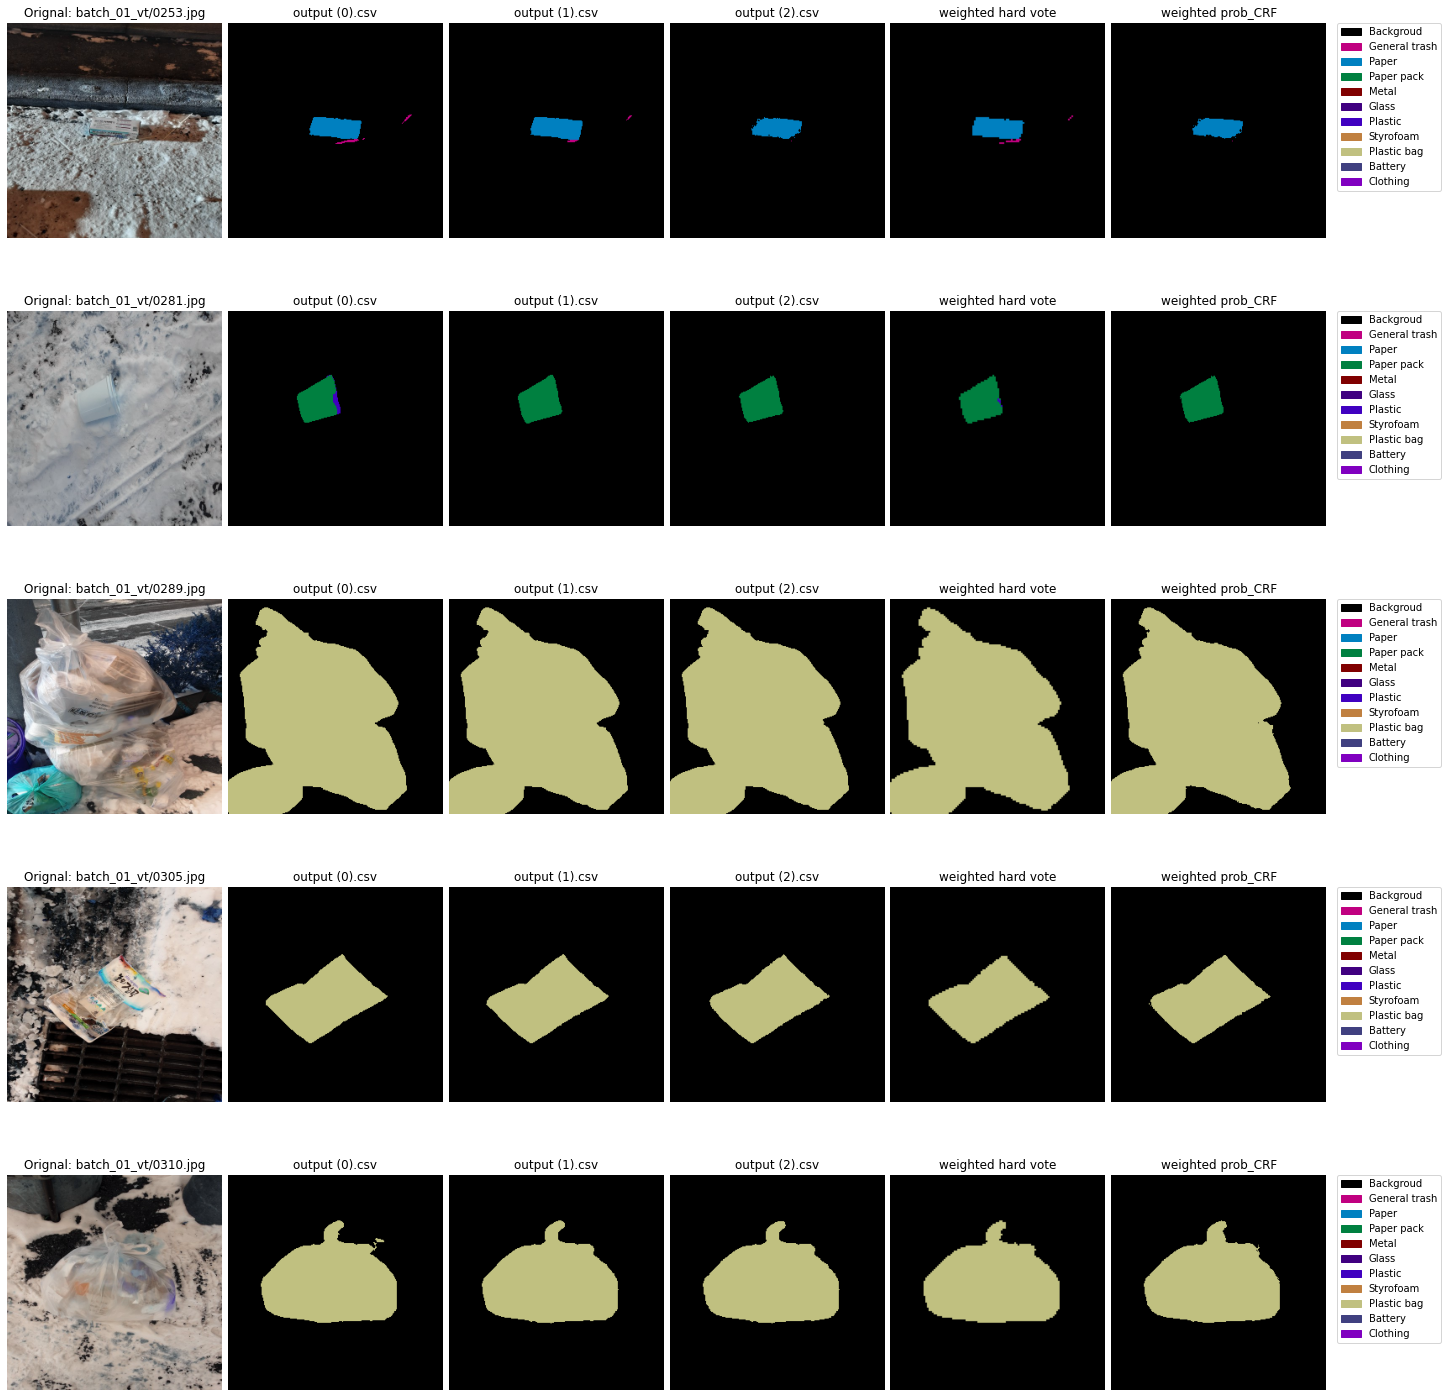

In [13]:
vis(index = 4*num_examples, **kwargs)

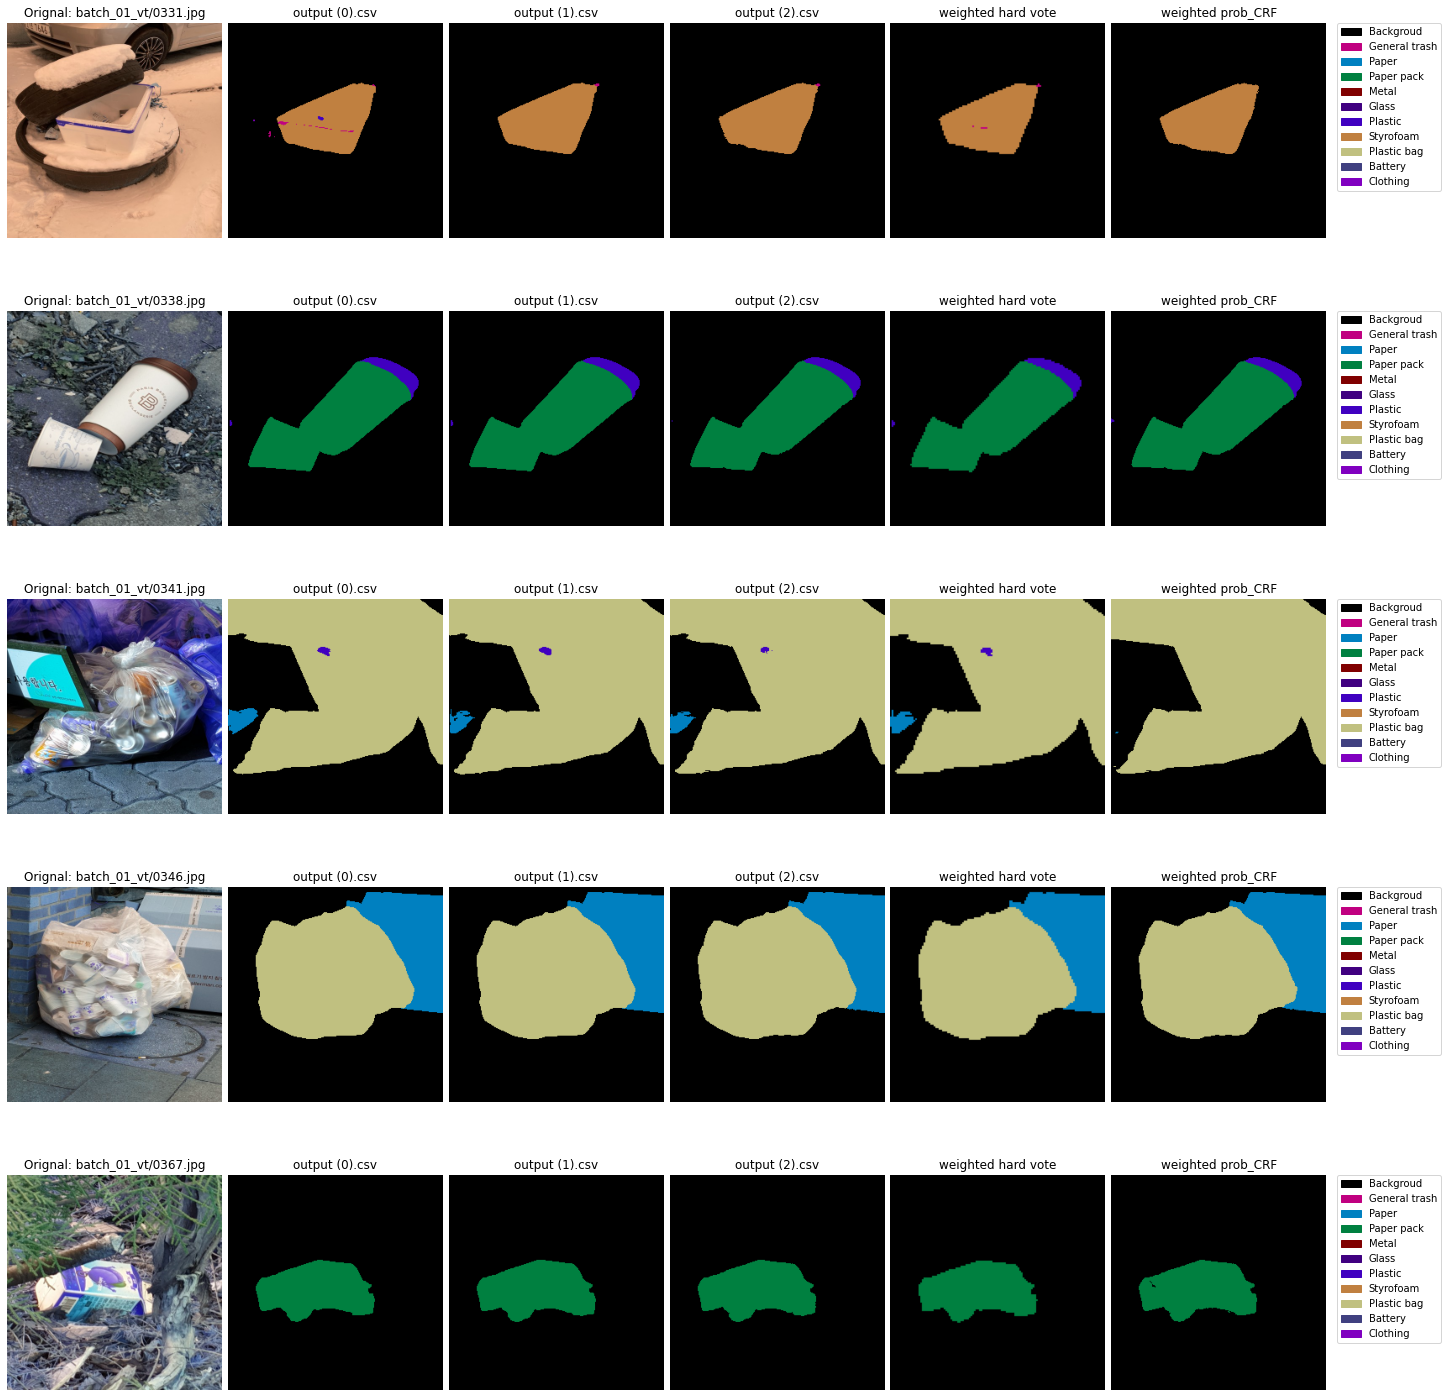

In [14]:
vis(index = 5*num_examples, **kwargs)

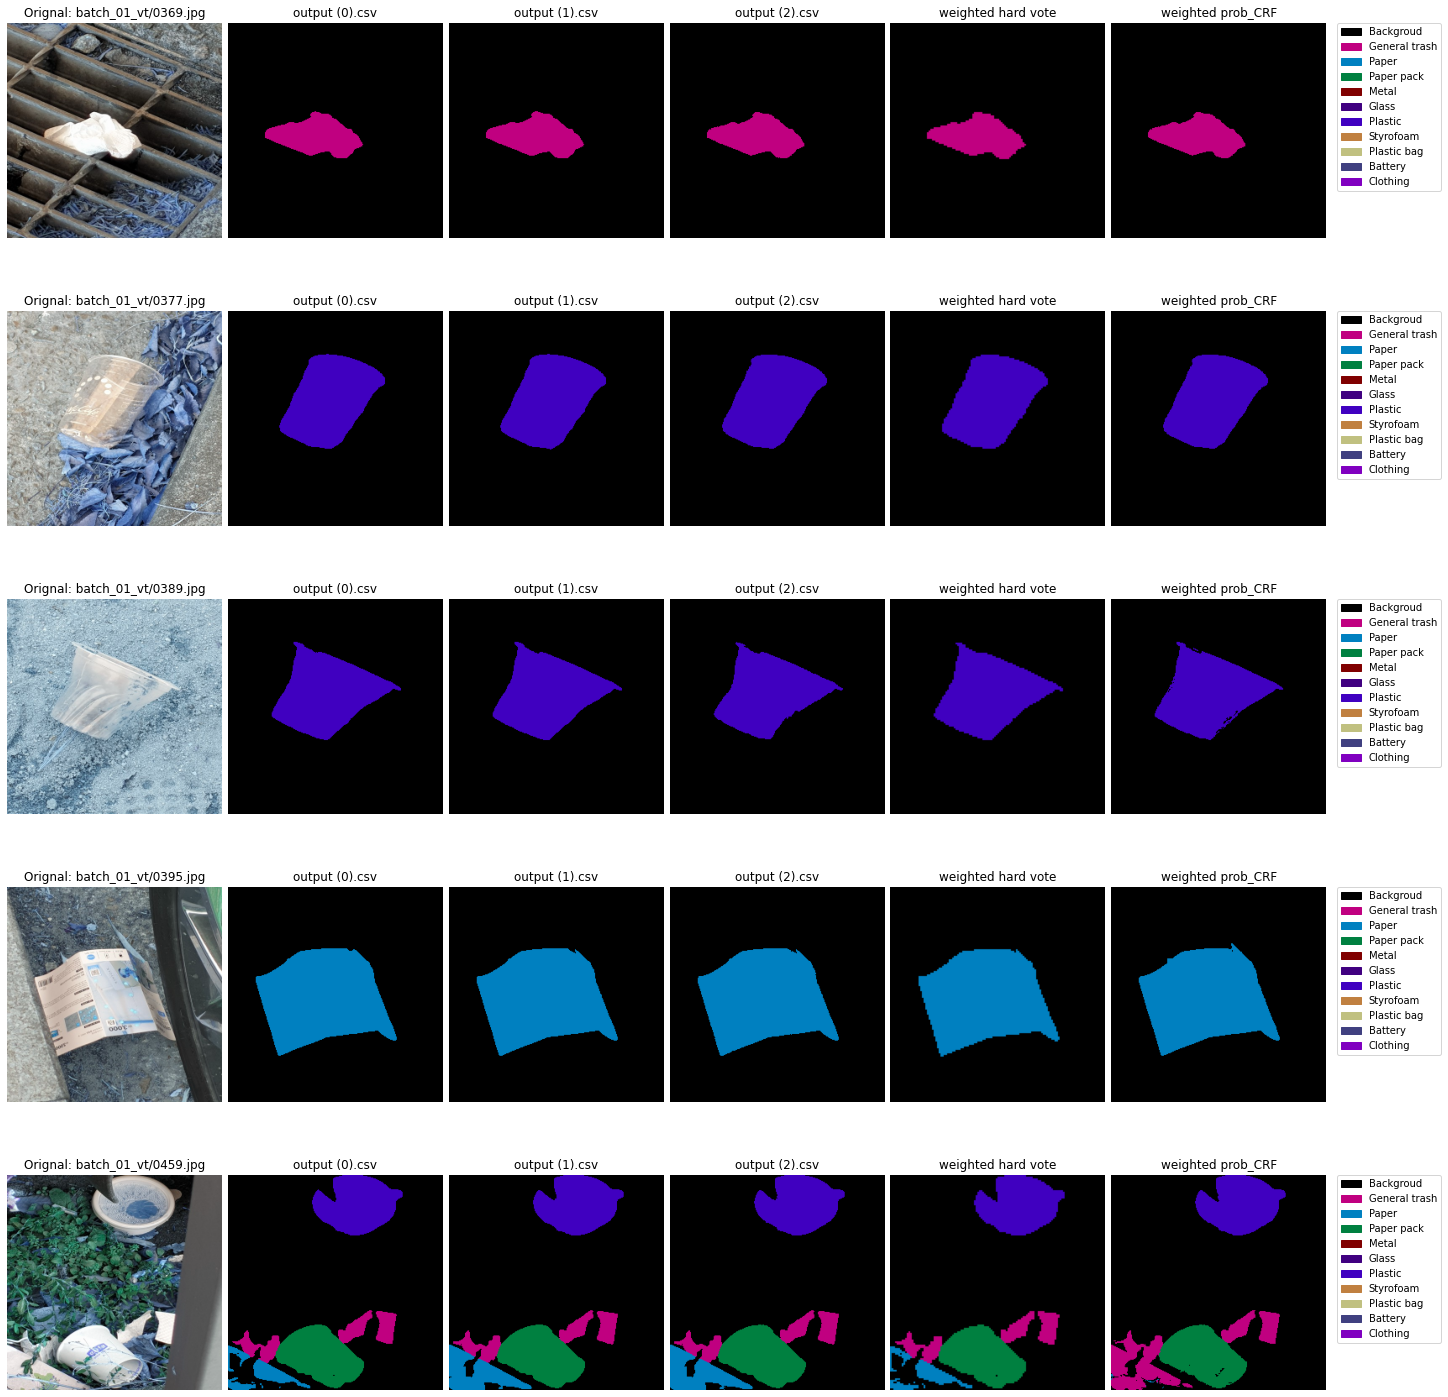

In [15]:
vis(index = 6*num_examples, **kwargs)

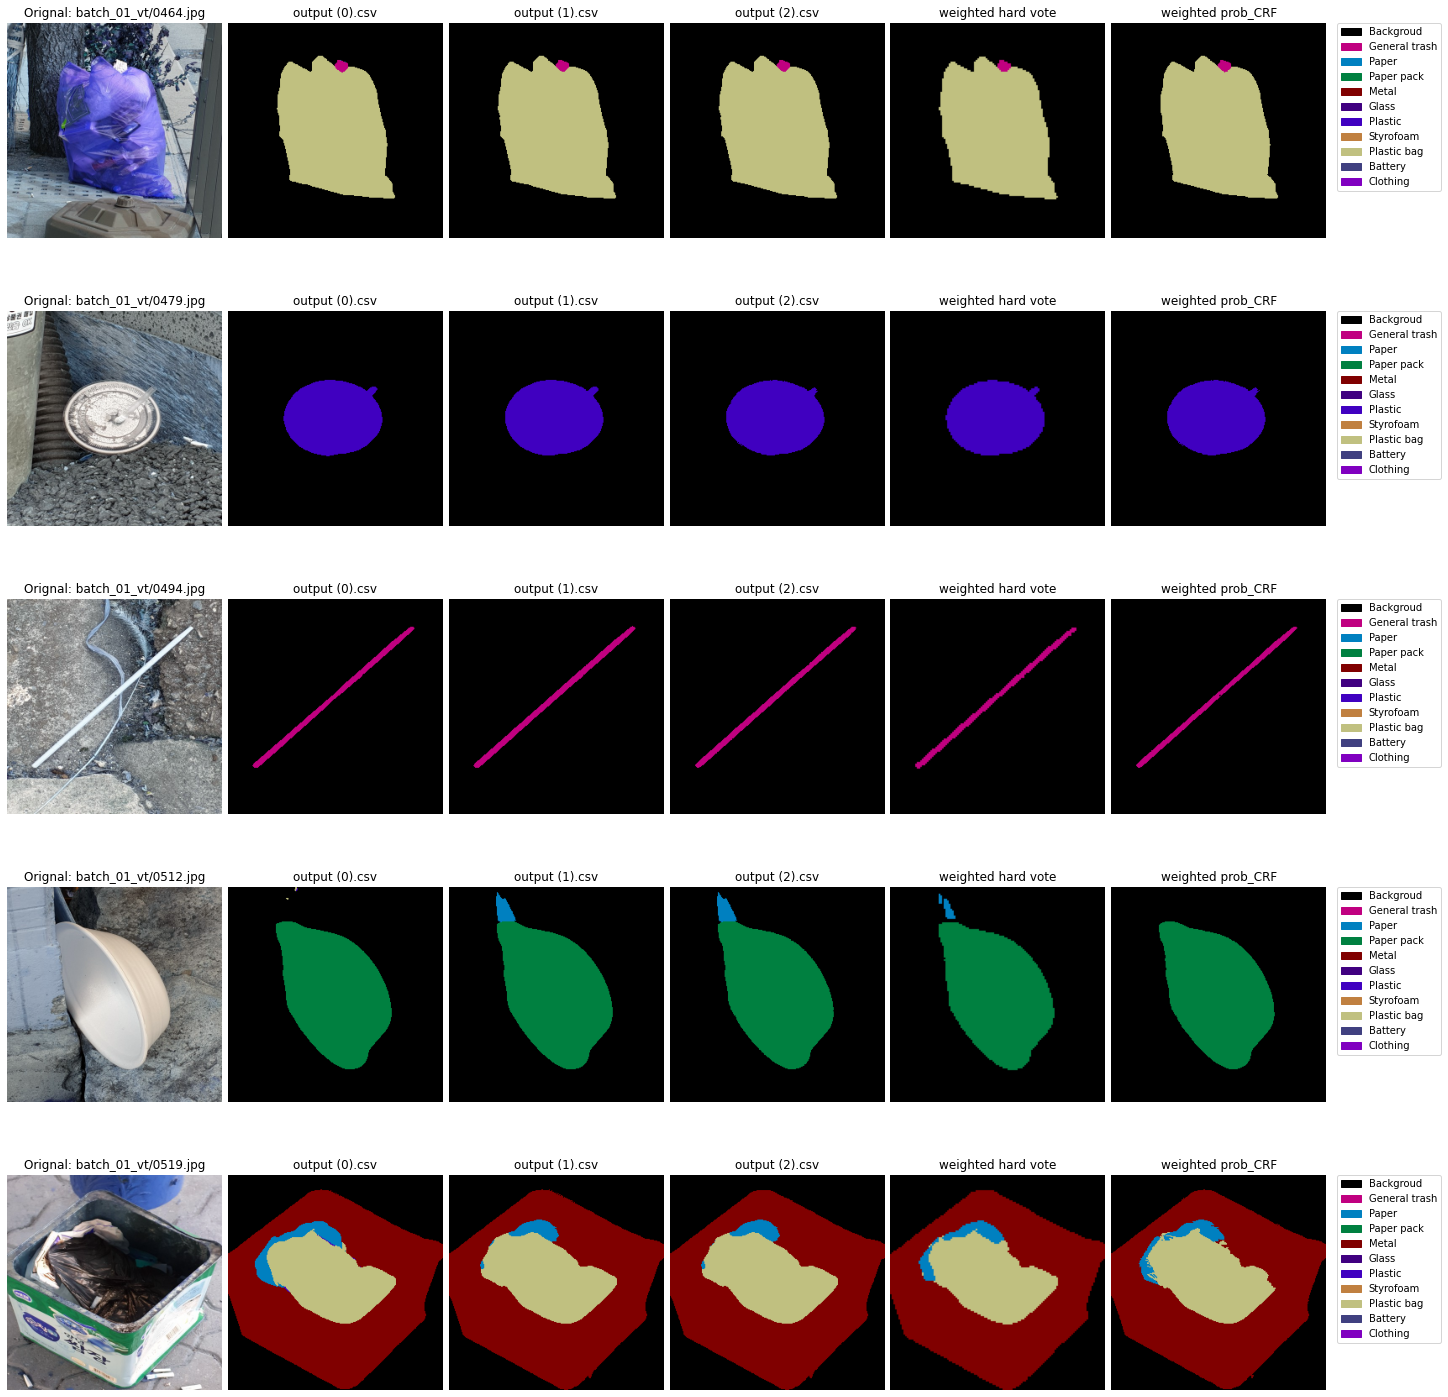

In [16]:
vis(index = 7*num_examples, **kwargs)

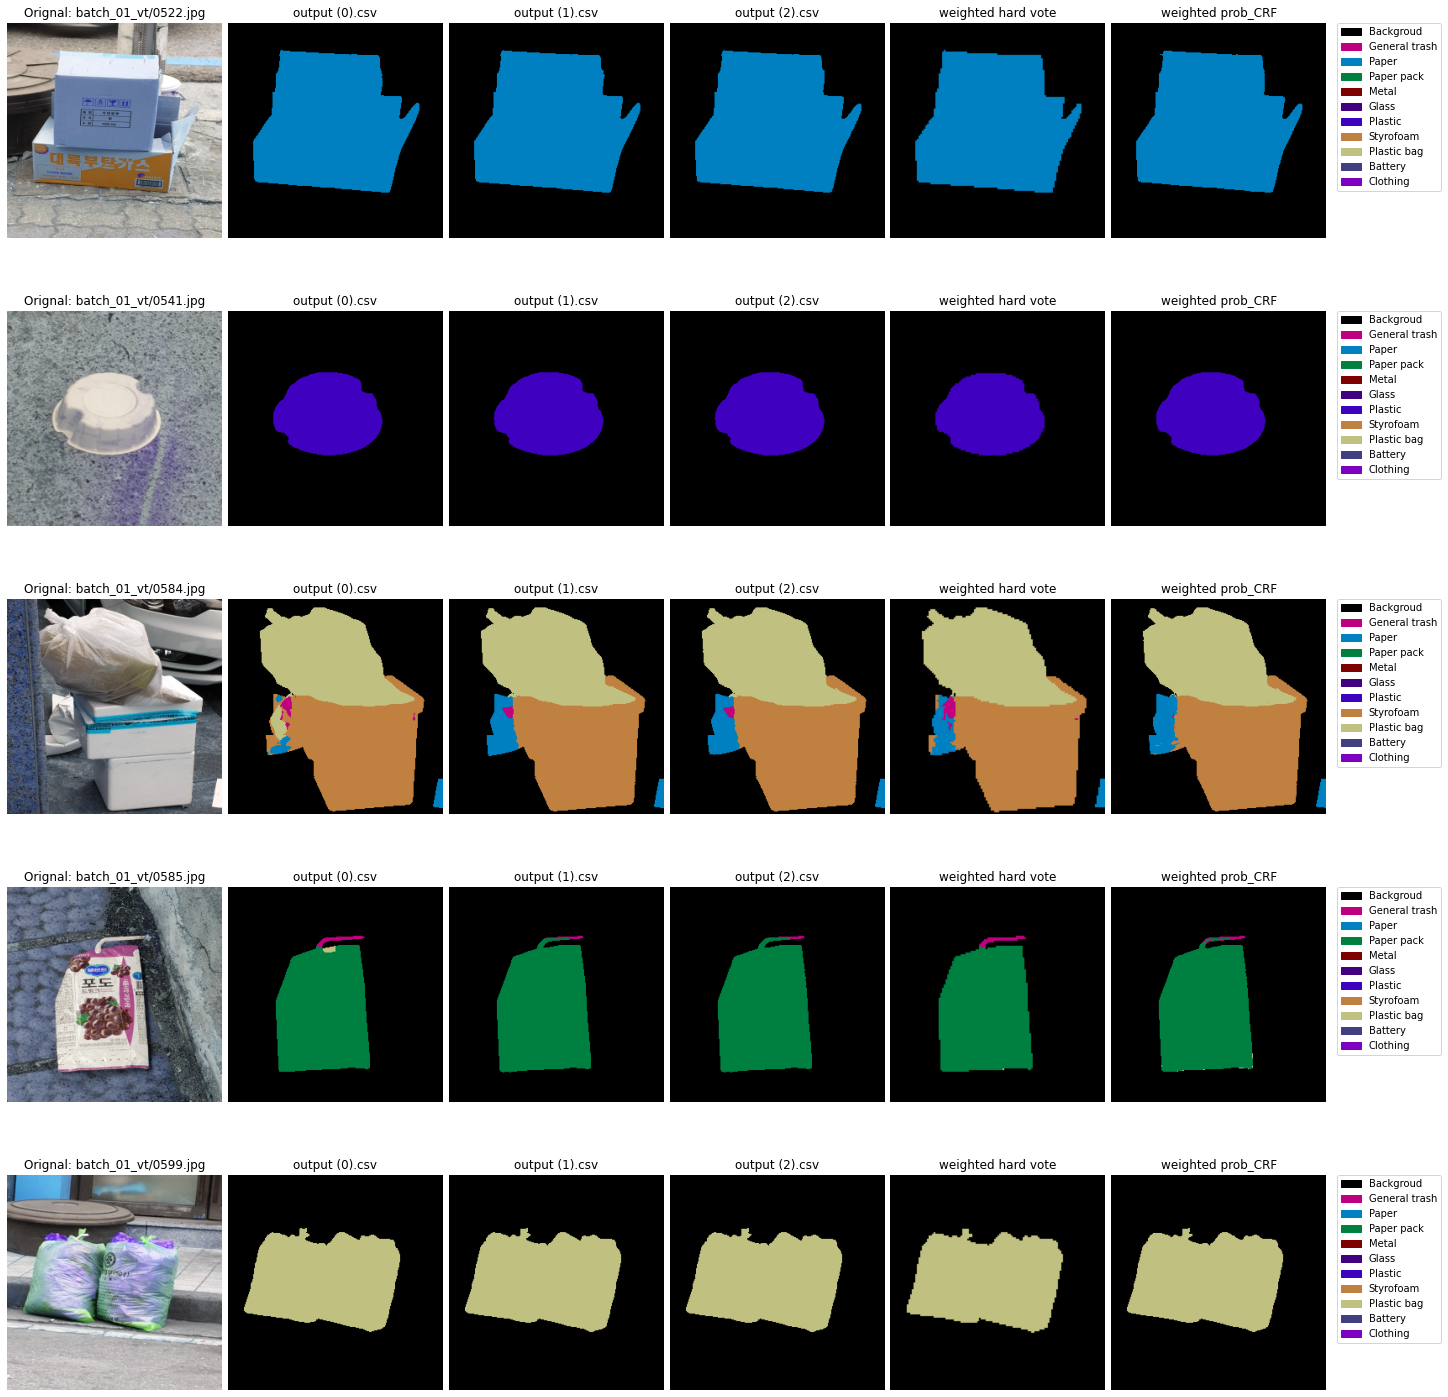

In [17]:
vis(index = 8*num_examples, **kwargs)

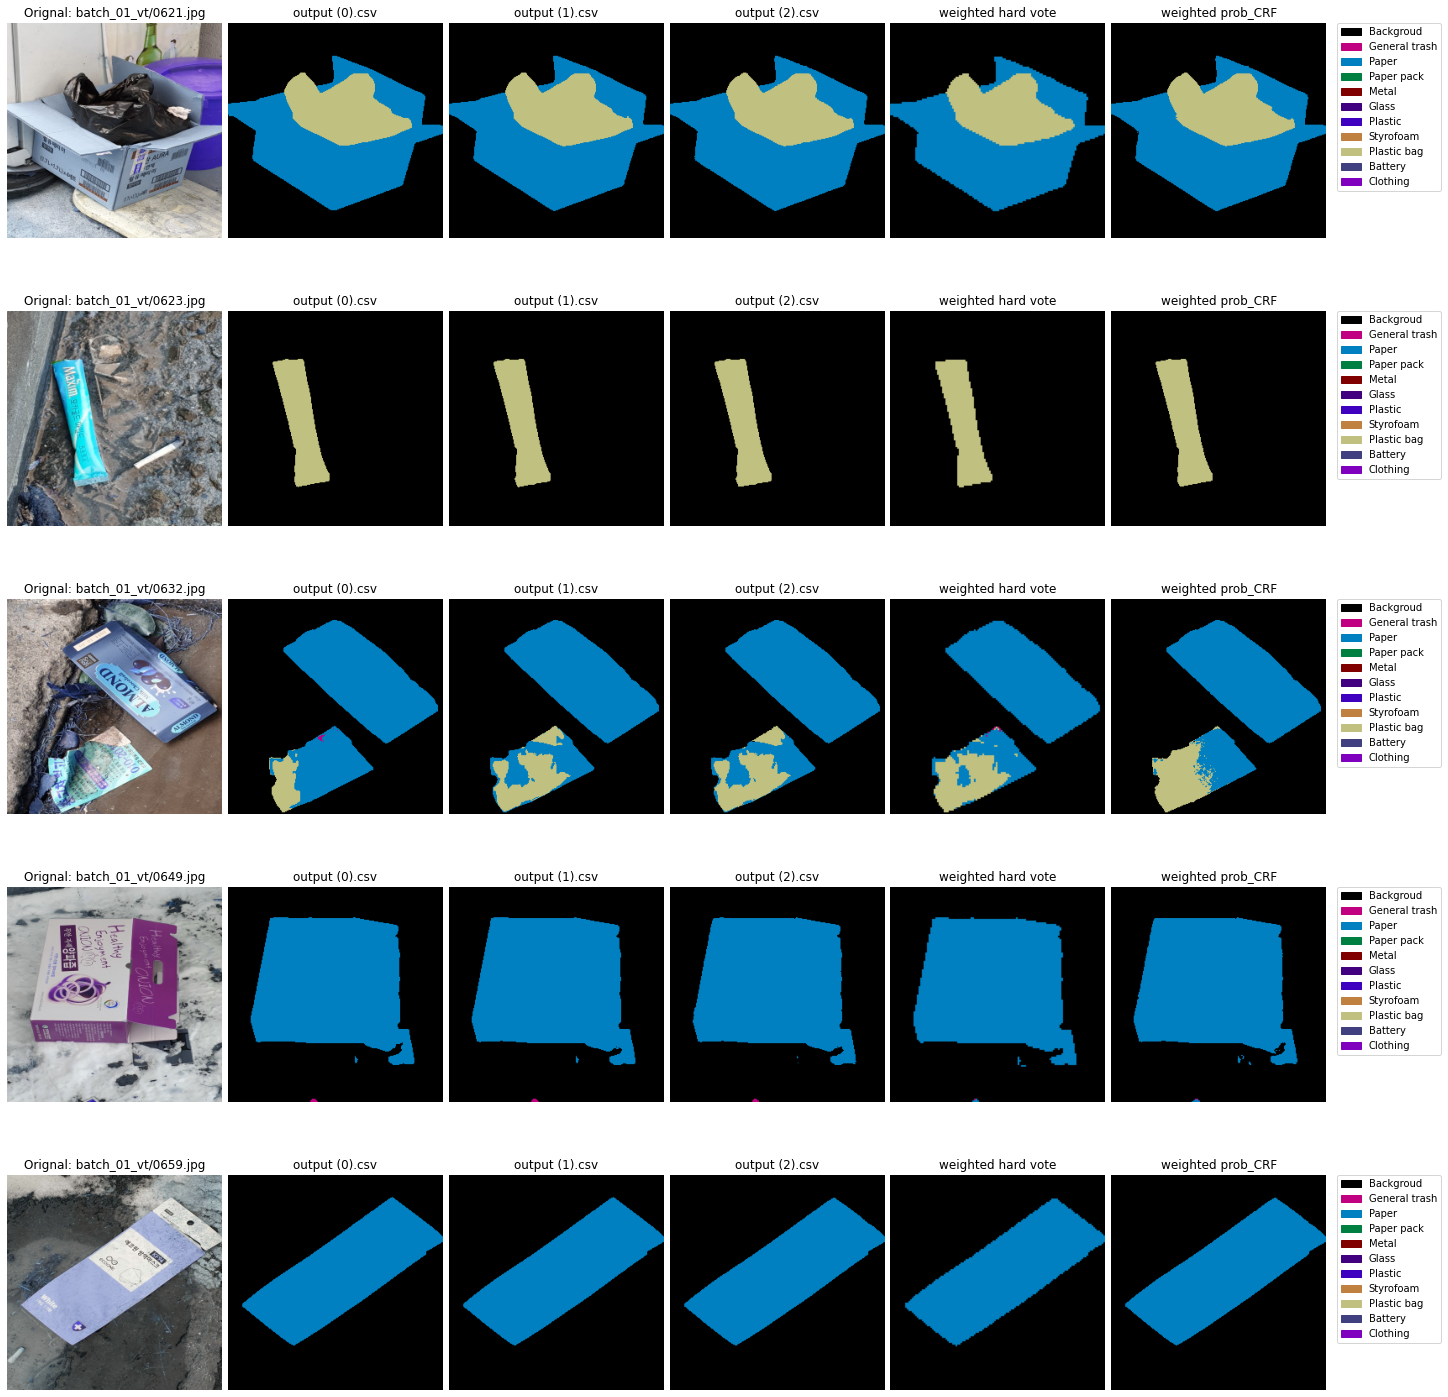

In [18]:
vis(index = 9*num_examples, **kwargs)

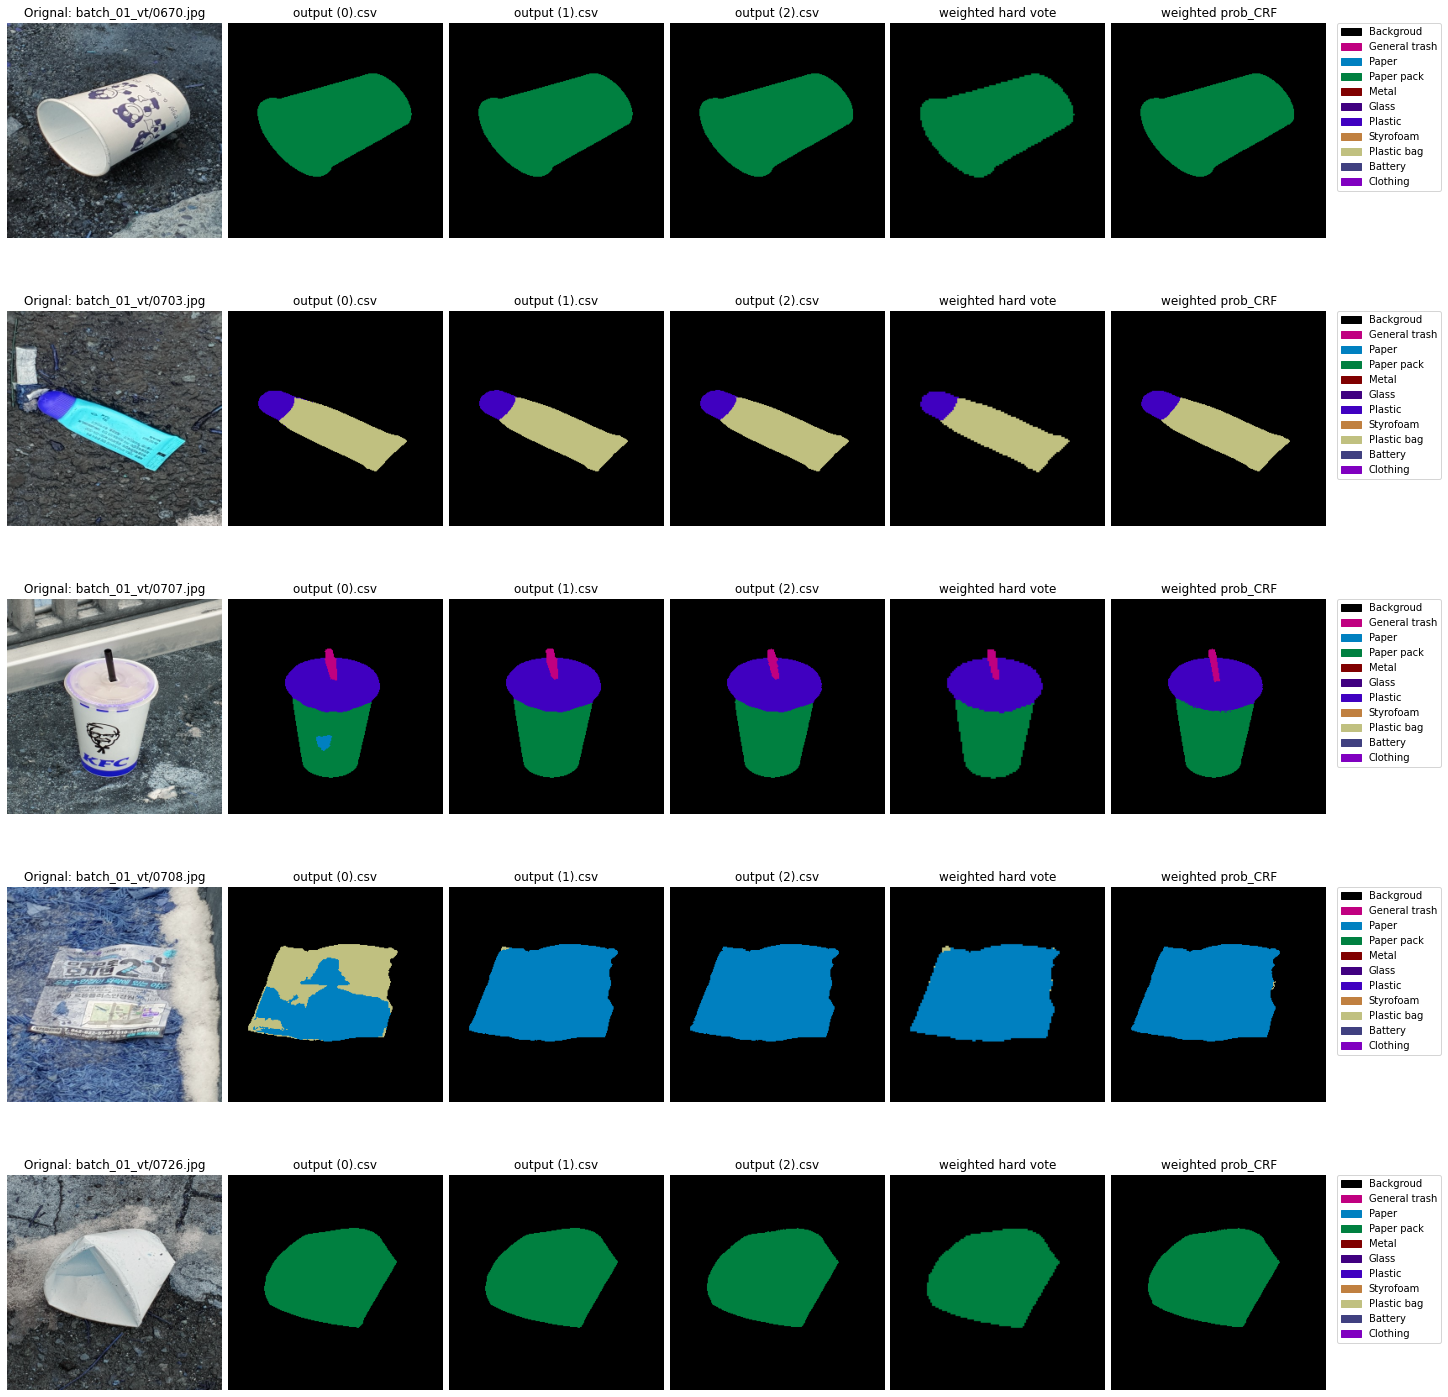

In [19]:
vis(index = 10*num_examples, **kwargs)

In [143]:
x = np.linspace(-3,3,100)
y = np.exp(-(x)**2)
y1 = np.exp(-(0.5)*(x)**2)
y2 = np.exp(-(0.2)*(x)**2)

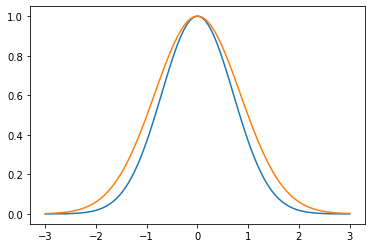

In [82]:
plt.plot(x,y)
plt.plot(x, y1 * y2)
plt.show()